## ***Contexto previo***

In [3]:
import nltk

nltk.download('reuters')
nltk.download('punkt_tab')

from nltk.corpus import reuters
from nltk import ngrams

[nltk_data] Downloading package reuters to
[nltk_data]     /home/uciencias/nltk_data...
[nltk_data]   Package reuters is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/uciencias/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [4]:
def preprocess_corpus(corpus: list[str]) -> list[str]:
    """Función de preprocesamiento

    Esta función está diseñada para preprocesar
    corpus para modelos del lenguaje neuronales.
    Agrega tokens de inicio y fin, normaliza
    palabras a minusculas
    """
    preprocessed_corpus = []
    for sent in corpus:
        result = [word.lower() for word in sent]
        # Al final de la oración
        result.append("<EOS>")
        result.insert(0, "<BOS>")
        preprocessed_corpus.append(result)
    return preprocessed_corpus

In [5]:
def get_words_freqs(corpus: list[list[str]]):
    """Calcula la frecuencia de las palabras en un corpus"""
    words_freqs = {}
    for sentence in corpus:
        for word in sentence:
            words_freqs[word] = words_freqs.get(word, 0) + 1
    return words_freqs

In [6]:
UNK_LABEL = "<UNK>"
def get_words_indexes(words_freqs: dict) -> dict:
    """Calcula los indices de las palabras dadas sus frecuencias"""
    result = {}
    for idx, word in enumerate(words_freqs.keys()):
        # Happax legomena happends
        if words_freqs[word] == 1:
            # Temp index for unknowns
            result[UNK_LABEL] = len(words_freqs)
        else:
            result[word] = idx

    return {word: idx for idx, word in enumerate(result.keys())}, {idx: word for idx, word in enumerate(result.keys())}

In [7]:
corpus = preprocess_corpus(reuters.sents())

In [8]:
len(corpus)

54716

In [9]:
words_freqs = get_words_freqs(corpus)

In [10]:
words_freqs["the"]

69277

In [11]:
len(words_freqs)

31079

In [12]:
count = 0
for word, freq in words_freqs.items():
    if freq == 1 and count <= 10:
        print(word, freq)
        count += 1

inflict 1
sheen 1
avowed 1
kilolitres 1
janunary 1
pineapples 1
hasrul 1
paian 1
sawn 1
goodall 1
bundey 1


In [13]:
words_indexes, index_to_word = get_words_indexes(words_freqs)

In [14]:
words_indexes["the"]

16

In [15]:
index_to_word[16]

'the'

In [16]:
len(words_indexes)

20056

In [17]:
len(index_to_word)

20056

In [18]:
def get_word_id(words_indexes: dict, word: str) -> int:
    """Obtiene el id de una palabra dada

    Si no se encuentra la palabra se regresa el id
    del token UNK
    """
    unk_word_id = words_indexes[UNK_LABEL]
    return words_indexes.get(word, unk_word_id)

### Obtenemos trigramas

Convertiremos los trigramas obtenidos a secuencias de idx, y preparamos el conjunto de entrenamiento $x$ y $y$

- x: Contexto
- y: Predicción de la siguiente palabra

In [19]:
def get_train_test_data(corpus: list[list[str]], words_indexes: dict, n: int) -> tuple[list, list]:
    """Obtiene el conjunto de train y test

    Requerido en el step de entrenamiento del modelo neuronal
    """
    x_train = []
    y_train = []
    for sent in corpus:
        n_grams = ngrams(sent, n)
        for w1, w2, w3 in n_grams:
            x_train.append([get_word_id(words_indexes, w1), get_word_id(words_indexes, w2)])
            y_train.append([get_word_id(words_indexes, w3)])
    return x_train, y_train

### Preparando Pytorch

$x' = e(x_1) \oplus e(x_2)$

$h = \tanh(W_1 x' + b)$

$y = softmax(W_2 h)$

In [21]:
# cargamos bibliotecas
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import time

In [22]:
# Setup de parametros
EMBEDDING_DIM = 200
CONTEXT_SIZE = 2
BATCH_SIZE = 256
H = 100
torch.manual_seed(42)
# Tamaño del Vocabulario
V = len(words_indexes)

In [23]:
x_train, y_train = get_train_test_data(corpus, words_indexes, n=3)

In [24]:
import numpy as np

train_set = np.concatenate((x_train, y_train), axis=1)
# partimos los datos de entrada en batches
train_loader = DataLoader(train_set, batch_size = BATCH_SIZE)

### Creamos la arquitectura del modelo

In [25]:
# Trigram Neural Network Model
class TrigramModel(nn.Module):
    """Clase padre: https://pytorch.org/docs/stable/generated/torch.nn.Module.html"""

    def __init__(self, vocab_size, embedding_dim, context_size, h):
        super(TrigramModel, self).__init__()
        self.context_size = context_size
        self.embedding_dim = embedding_dim
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(context_size * embedding_dim, h)
        self.linear2 = nn.Linear(h, vocab_size)

    def forward(self, inputs):
        # x': concatenation of x1 and x2 embeddings   -->
        # self.embeddings regresa un vector por cada uno de los índices que se les pase como entrada.
        # view() les cambia el tamaño para concatenarlos
        embeds = self.embeddings(inputs).view((-1,self.context_size * self.embedding_dim))
        # h: tanh(W_1.x' + b)  -->
        out = torch.tanh(self.linear1(embeds))
        # W_2.h                 -->
        out = self.linear2(out)
        # log_softmax(W_2.h)      -->
        # dim=1 para que opere sobre renglones, pues al usar batchs tenemos varios vectores de salida
        log_probs = F.log_softmax(out, dim=1)

        return log_probs

In [39]:
# Seleccionar la GPU si está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [46]:
def get_model(path: str) -> TrigramModel:
    """Obtiene modelo de pytorch desde disco"""
    model_loaded = TrigramModel(V, EMBEDDING_DIM, CONTEXT_SIZE, H)
    model_loaded.load_state_dict(torch.load(path, map_location=device, weights_only=False)) # Modificación para pasar de device sin problema
    model_loaded.eval()
    return model_loaded

In [47]:
PATH = "models/model_cuda_context_2_epoch_33.dat"
model = get_model(PATH)

In [48]:
model

TrigramModel(
  (embeddings): Embedding(20056, 200)
  (linear1): Linear(in_features=400, out_features=100, bias=True)
  (linear2): Linear(in_features=100, out_features=20056, bias=True)
)

In [49]:
W1 = "<BOS>"
W2 = "my"

IDX1 = get_word_id(words_indexes, W1)
IDX2 = get_word_id(words_indexes, W2)

#Obtenemos Log probabidades p(W3|W2,W1)
probs = model(torch.tensor([[IDX1,  IDX2]]).to(device)).detach().tolist()

In [50]:
len(probs[0])

20056

In [51]:
# Creamos diccionario con {idx: logprob}
model_probs = {}
for idx, p in enumerate(probs[0]):
  model_probs[idx] = p

# Sort:
model_probs_sorted = sorted(((prob, idx) for idx, prob in model_probs.items()), reverse=True)

# Printing word  and prob (retrieving the idx):
topcandidates = 0
for prob, idx in model_probs_sorted:
  #Retrieve the word associated with that idx
  word = index_to_word[idx]
  print(idx, word, prob)

  topcandidates += 1

  if topcandidates > 10:
    break

31 <UNK> -1.7069592475891113
2462 aim -1.8499627113342285
5940 feeling -3.326193332672119
499 department -3.4385533332824707
600 bank -3.5342421531677246
1022 see -3.820742607116699
3232 cold -4.458005428314209
251 view -4.47383975982666
3217 social -4.530029773712158
3828 comments -4.578963756561279
10991 enrolled -4.6734490394592285


In [53]:
print(index_to_word.get(model_probs_sorted[1][1]))

aim


### Generacion de lenguaje

In [54]:
def get_likely_words(model: TrigramModel, context: str, words_indexes: dict, index_to_word: dict, top_count: int=10) -> list[tuple]:
    model_probs = {}
    words = context.split()
    idx_word_1 = get_word_id(words_indexes, words[0])
    idx_word_2 = get_word_id(words_indexes, words[1])
    probs = model(torch.tensor([[idx_word_1, idx_word_2]]).to(device)).detach().tolist()

    for idx, p in enumerate(probs[0]):
        model_probs[idx] = p

    # Strategy: Sort and get top-K words to generate text
    return sorted(((prob, index_to_word[idx]) for idx, prob in model_probs.items()), reverse=True)[:top_count]

In [55]:
sentence = "this is"
get_likely_words(model, sentence, words_indexes, index_to_word, 3)

[(-1.432661533355713, 'a'),
 (-2.086770534515381, 'the'),
 (-2.9159011840820312, 'entirely')]

In [56]:
from random import randint

def get_next_word(words: list[tuple[float, str]]) -> str:
    # From a top-K list of words get a random word
    return words[randint(0, len(words)-1)][1]

In [57]:
get_next_word(get_likely_words(model, sentence, words_indexes, index_to_word))

'the'

In [58]:
MAX_TOKENS = 50
TOP_COUNT = 10
def generate_text(model: TrigramModel, history: str, words_indexes: dict, index_to_word: dict, tokens_count: int=0) -> None:
    next_word = get_next_word(get_likely_words(model, history, words_indexes, index_to_word, top_count=TOP_COUNT))
    print(next_word, end=" ")
    tokens_count += 1
    if tokens_count == MAX_TOKENS or next_word == "<EOS>":
        return
    generate_text(model, history.split()[1]+ " " + next_word, words_indexes, index_to_word, tokens_count)

In [59]:
sentence = "mexico is"
print(sentence, end=" ")
generate_text(model, sentence, words_indexes, index_to_word)

mexico is that it would refer u for blocking japanese dumping for quite a party . . to help strengthen its efforts , which was released to specify what was being written down this stability that would interfere to have an increase for february to march 20 , and a further yen 

# Práctica 4: Modelos del Lenguaje Neuronales

**Fecha de entrega: 6 de abril de 2025 11:59pm**

A partir del modelo entrenado:

## ***Ejercicio 1***
- Sacar los embeddings de las palabras del vocabulario

In [60]:
embeddings = model.embeddings.weight.data.cpu().numpy()

embeddings_dict = {word: embeddings[idx] for idx, word in index_to_word.items()}
print(f"Embedding de 'mexico': {embeddings_dict['mexico']}")

Embedding de 'mexico': [ 0.30697015  0.7881475  -1.647695   -2.5035212  -0.79140186 -0.03954964
 -0.658335    0.5177193  -1.2830713  -0.76542586 -0.31349558  0.18312187
  1.2726498  -0.07906369  1.1356677  -0.17667668  0.96809024 -1.0156804
 -1.1373731   0.04864923  0.13456899  0.67258215  0.7695442   0.44488457
  0.59040785 -0.42595908 -0.3143384   0.5510495  -1.1710438  -2.241557
  0.45677263 -0.73737055  1.0532143   0.5452703   0.58049405 -1.4498322
  1.193215   -0.2338191   0.23555134 -0.5503838   2.5338805   1.5420345
  3.2527082   0.07142363  0.36187753 -3.045706    4.339475    1.0019208
 -0.18638258 -0.96454346  0.77737164 -0.66654146  0.3925497  -0.47772375
  0.73646766 -1.6237586   0.04137879  0.83899385  1.2397169   1.1417763
 -0.45794892  2.0548549  -1.8152661  -0.955427   -1.0013145  -2.8867905
  0.39958996  2.420503   -2.8487613  -0.46724924 -1.5844587  -0.86114484
 -0.05738772  2.9725468   0.34606186 -0.56268764 -0.41352874  1.6780319
  1.1493057   1.4483129  -0.8758926  

## ***Ejercicio 2***
- Visualizar en 2D los embeddings de algunas palabras (quizá las más frecuentes, excluyendo stopwords)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/uciencias/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


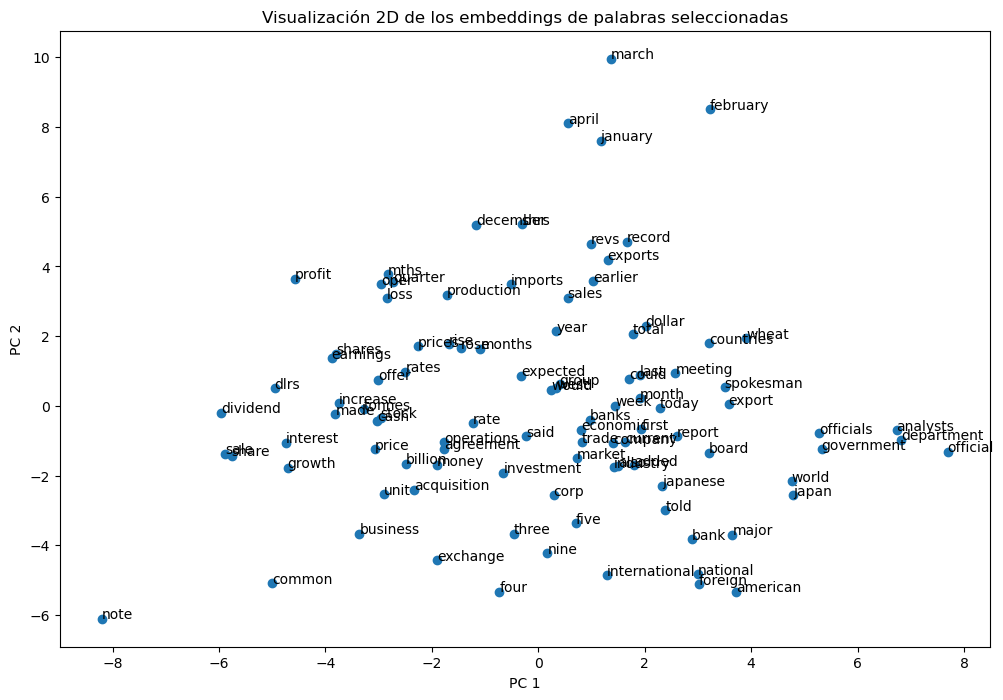

In [61]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from nltk.corpus import stopwords
nltk.download('stopwords')

# Obtener stopwords en inglés (descárgalas si aún no lo has hecho: nltk.download('stopwords'))
stop_words = set(stopwords.words('english'))

# Seleccionar palabras: solo aquellas alfabéticas y no stopwords, ordenadas por frecuencia
frequent_words = sorted(
    [(word, freq) for word, freq in words_freqs.items() if word.isalpha() and word not in stop_words and len(word) > 3],
    key=lambda x: x[1],
    reverse=True
)

# Tomamos, por ejemplo, las 100 palabras más frecuentes
selected_words = [word for word, freq in frequent_words[:100]]
selected_indices = [words_indexes[word] for word in selected_words if word in words_indexes]

# Subconjunto de embeddings
selected_embeddings = embeddings[selected_indices]

# Reducir dimensiones con PCA a 2 componentes
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(selected_embeddings)

# Plot
plt.figure(figsize=(12, 8))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1])
for i, word in enumerate(selected_words):
    plt.annotate(word, (embeddings_2d[i, 0], embeddings_2d[i, 1]))
plt.title("Visualización 2D de los embeddings de palabras seleccionadas")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.show()

Como se puede apreciar no sale un buen resultado con PCA. Por lo tanto, vamos a probar con métodos no lineales para ver que tal funciona. 

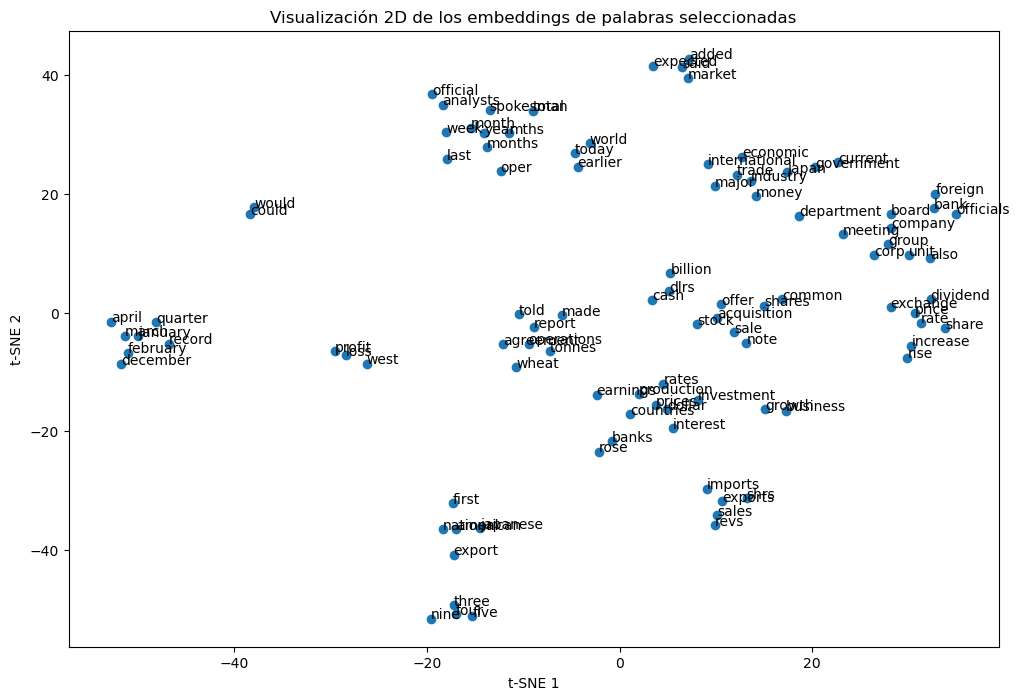

In [62]:
from sklearn.manifold import TSNE

pca = PCA()  # Reducción intermedia
embeddings_pca = pca.fit_transform(selected_embeddings)

# UMAP sobre PCA
umap = TSNE(n_components=2, perplexity=2, random_state=42)
embeddings_2d = umap.fit_transform(embeddings_pca)

# Visualización
plt.figure(figsize=(12, 8))
plt.scatter(embeddings_2d[:,0], embeddings_2d[:,1])
plt.title("Visualización 2D de los embeddings de palabras seleccionadas")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
for i, word in enumerate(selected_words):
    plt.annotate(word, (embeddings_2d[i,0], embeddings_2d[i,1]))

Como se puede apreciar, con un perplexity bajo si se pueden identificar algunas similitudes entre palabras.

/home/uciencias/anaconda3/envs/nlp/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/uciencias/anaconda3/envs/nlp/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


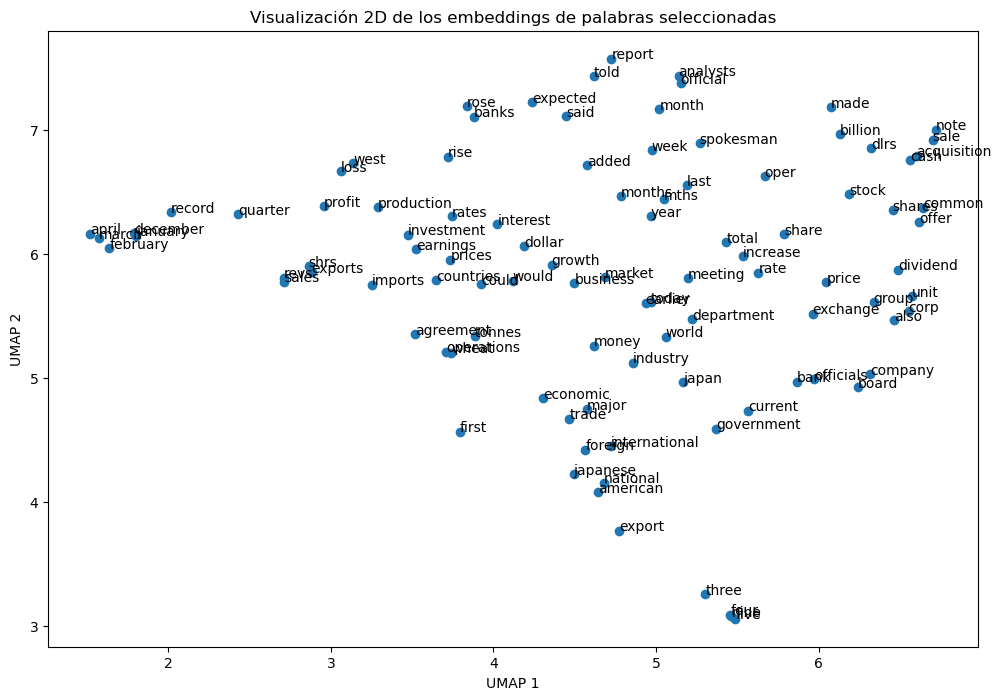

In [64]:
from umap import UMAP
# PCA inicial
pca = PCA()  # Reducción intermedia
embeddings_pca = pca.fit_transform(selected_embeddings)

# UMAP sobre PCA
umap = UMAP(n_components=2, n_neighbors=7, min_dist=0.0, random_state=42)
embeddings_2d = umap.fit_transform(embeddings_pca)

# Visualización
plt.figure(figsize=(12, 8))
plt.scatter(embeddings_2d[:,0], embeddings_2d[:,1])
plt.title("Visualización 2D de los embeddings de palabras seleccionadas")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
for i, word in enumerate(selected_words):
    plt.annotate(word, (embeddings_2d[i,0], embeddings_2d[i,1]))

Este método a, de la misma forma que con t-SNE, presenta una mejor agrupación pero sin ser excesiva como en t-SNE.

## ***Ejercicio 3***
- Seleccione algunas palabras y verifique sí realmente codifican nociones semánticas, e,g, similitud semántica con similitud coseno entre dos vectores, analogías por medios de operaciones de vectores

Se verificará que se codifiquen nociones semánticas a través de la similitud coseno y analogías. Se utilizará la biblioteca `gensim` para este fin. 

In [66]:
from gensim.models import KeyedVectors

kv = KeyedVectors(vector_size=EMBEDDING_DIM)
words = list(embeddings_dict.keys())
vectors = list(embeddings_dict.values())
kv.add_vectors(words, vectors)

In [81]:
print("Similitud entre 'profit' y 'loss':", kv.similarity("profit", "loss"))
print("Similitud entre 'march' y 'april':", kv.similarity("march", "april"))
print("Similitud entre 'oil' y 'gas':", kv.similarity("oil", "gas"))
print("Similitud entre 'merger' y 'acquisition':", kv.similarity("merger", "acquisition"))
print("Similitud entre 'president' y 'government':", kv.similarity("president", "government"))

Similitud entre 'profit' y 'loss': 0.44155478
Similitud entre 'march' y 'april': 0.44152722
Similitud entre 'oil' y 'gas': 0.2105621
Similitud entre 'merger' y 'acquisition': 0.3339324
Similitud entre 'president' y 'government': -0.022489036


In [77]:
result = kv.most_similar(positive=["berlin", "italy"], negative=["germany"], topn=5)
print("Analogía: 'berlin' - 'germany' + 'italy':")
for i, v in enumerate(result):
    print(f"{i+1}. {v}")

result = kv.most_similar(positive=["government", "president"], negative=["election"], topn=5)
print("\nAnalogía: 'president' - 'election' + 'government':")
for i, v in enumerate(result):
    print(f"{i+1}. {v}")

result = kv.most_similar(positive=["oil", "consumer"], negative=["producer"], topn=5)
print("\nAnalogía: 'oil' - 'producer' + 'consumer':")
for i, v in enumerate(result):
    print(f"{i+1}. {v}")

result = kv.most_similar(positive=["bank", "market"], negative=["loan"], topn=5)
print("\nAnalogía: 'bank' - 'loan' + 'market':")
for i, v in enumerate(result):
    print(f"{i+1}. {v}")

Analogía: 'berlin' - 'germany' + 'italy':
1. ('well', 0.2830544114112854)
2. ('denko', 0.2653278410434723)
3. ('theodor', 0.26160985231399536)
4. ('rio', 0.25659358501434326)
5. ('posts', 0.25380629301071167)

Analogía: 'president' - 'election' + 'government':
1. ('avy', 0.3128959834575653)
2. ('comex', 0.28858909010887146)
3. ('guin', 0.2655089795589447)
4. ('salaried', 0.26353713870048523)
5. ('paks', 0.25895071029663086)

Analogía: 'oil' - 'producer' + 'consumer':
1. ('promotional', 0.27939391136169434)
2. ('grace', 0.2592107951641083)
3. ('household', 0.2544364333152771)
4. ('bilion', 0.2534409165382385)
5. ('naphtha', 0.25130683183670044)

Analogía: 'bank' - 'loan' + 'market':
1. ('prominently', 0.29588374495506287)
2. ('overhauls', 0.28362858295440674)
3. ('caucasus', 0.27334481477737427)
4. ('arrival', 0.2640206217765808)
5. ('coulson', 0.26119887828826904)


## Extra (0.5 pts):

- Correr el modelo de Bengio pero aplicando una técnica de subword tokenization al corpus y hacer generación del lenguaje

* La generación del lenguaje debe ser secuencias de palabras (no subwords)

Entregué la práctica tarde por el extra, pero creo que ni me salió F. Total que esta es mi implementación. 

In [117]:
from tokenizers import Tokenizer
from tokenizers.models import BPE 
from tokenizers.trainers import BpeTrainer
from tokenizers.processors import TemplateProcessing
from tokenizers.pre_tokenizers import Punctuation, Sequence, Whitespace
import random 

Primero volvemos a definir nuestro corpus de reuters per eliminando espacios finales o dobles espacios y pasando todo a minúsculas.

In [83]:
corpus = [
    " ".join(sentence).strip().replace("  ", " ").lower()
    for sentence in reuters.sents()
]

Antes de la tokenización se aplicará una pre tokenización donde se separarán los símbolos de las palabras y se dividirá por espacios en blanco. 

Ahora establecemos el tokenizador con Tokenizer, este será a través de BPE y definiremos nuestros tokens especiales como `<UNK>`, `<BOS>` y `<EOS>`. Además, establecemos un máximo de tamaño de vocabulario de 5,000. La frecuencia mínima para juntar dos subunidades será de 2 con tal de reducir el ruido. 

Finalmente, se añadió las etiquetas de final e inicio de oración al corpus tokenizado.

In [104]:
print("Iniciando proceso de tokenización...")

# Definimos nuestro tokenizador con BPE 
tokenizer = Tokenizer(BPE(unk_token="<UNK>"))


# Proceso previo a la tokenización
tokenizer.pre_tokenizer = Sequence([
    Whitespace(), 
    Punctuation()
])

# Tokenización
trainer = BpeTrainer(
    special_tokens=["<UNK>", "<BOS>", "<EOS>"],
    vocab_size=5_000,
    min_frequency=2
)
tokenizer.train_from_iterator(corpus, trainer=trainer)

# Post tokenización
tokenizer.post_processor = TemplateProcessing(
    single="<BOS> $A <EOS>",
    special_tokens=[
        ("<BOS>", tokenizer.token_to_id("<BOS>")),
        ("<EOS>", tokenizer.token_to_id("<EOS>"))
    ]
)

print("Proceso de tokenización finalizado...")

Iniciando proceso de tokenización...



Proceso de tokenización finalizado...


In [105]:
text = "Zyntriax shares plummet 30% in Tokyo".lower()
encoded = tokenizer.encode(text)
print(encoded.tokens)

['<BOS>', 'zy', 'n', 'tr', 'ia', 'x', 'shares', 'pl', 'um', 'met', '30', '<UNK>', 'in', 'tokyo', '<EOS>']


In [107]:
text = "Microsoft acquires new startup".lower()
encoded = tokenizer.encode(text)
print(encoded.tokens)

['<BOS>', 'micro', 'soft', 'acquires', 'new', 'start', 'up', '<EOS>']


In [108]:
def get_ngram_data(tokenized_sentences: list[list[str]], 
                   n: int=3) -> tuple[list[list[str]], list[str]]:
    """
    Genera pares (contexto, objetivo) para entrenamietno de modelos n-gram.

    :param tokenized_sentences: Lista de oreaciones tokenizadas.
    :type tokenized_sentences: list[list[str]]
    :param n: Orden del n-grama (default=3 para trigramas)
    :type n: int
    :return: Tupla con listas de contextos y targets
    :rtype: tuple[list[list[str]], list[str]]
    """
    contexts = []
    targets = []
    for sentence in tokenized_sentences:
        # Se ignoran oraciones demasiado cortas
        if len(sentence) < n:
            continue
        # Extraer n-gramas consecutivos
        for i in range(len(sentence) - n + 1):
            ngram = sentence[i: i + n]
            contexts.append(ngram[:-1])  # Dos primeros tokens como contexto
            targets.append(ngram[-1])    # El tercer token como objetivo
    return contexts, targets

In [110]:
encoded_corpus = [tokenizer.encode(sentence).ids for sentence in corpus]
contexts, targets = get_ngram_data(encoded_corpus, n=3)

In [112]:
# Parámetros del modelo
V = tokenizer.get_vocab_size()  # Debe ser 5000 (o cercano, según el trainer)
embedding_dim = 200
context_size = 2   # En un trigram, el contexto son 2 tokens
hidden_dim = 100

In [113]:
model = get_model("models/trigram_model_cuda.pt")

In [114]:
model

TrigramModel(
  (embeddings): Embedding(5000, 200)
  (linear1): Linear(in_features=400, out_features=100, bias=True)
  (linear2): Linear(in_features=100, out_features=5000, bias=True)
)

In [125]:
def generate_text(model: TrigramModel, initial_context: str, tokenizer: Tokenizer, max_tokens: int = 50, top_count: int = 10) -> str:
    """
    Genera texto a partir del modelo de trigramas acumulando los IDs generados
    y luego decodificándolos para obtener palabras completas.

    :param model: el modelo de trigramas entrenado.
    :param initial_context: cadena de texto inicial (al menos 2 tokens).
    :param tokenizer: el tokenizer BPE entrenado.
    :param max_tokens: número máximo de tokens a generar (incluyendo el contexto inicial).
    :param top_count: número de candidatos top a considerar en cada paso.
    :return: El texto generado (cadena) tras decodificar la secuencia de tokens.
    :rtype: str
    """
    # Obtenemos la secuencia inicial en IDs a partir del contexto dado
    generated_ids = tokenizer.encode(initial_context).ids

    # Aseguramos que el contexto para el modelo sea de 2 tokens (rellenando con <BOS> si es necesario)
    if len(generated_ids) < 2:
        bos_id = tokenizer.token_to_id("<BOS>")
        generated_ids = [bos_id] * (2 - len(generated_ids)) + generated_ids

    # Definimos el contexto inicial para el modelo como los dos últimos tokens de la secuencia
    context = generated_ids[-2:]

    for _ in range(max_tokens):
        # Preparamos el tensor de entrada (con dimensión de batch 1)
        input_tensor = torch.tensor([context], dtype=torch.long, device=device)
        # Obtenemos las log-probabilidades del modelo para el siguiente token
        log_probs = model(input_tensor)
        log_probs = log_probs.squeeze(0).detach().cpu().tolist()  # [vocab_size]

        # Seleccionar top_count candidatos (por índices y sus log-prob)
        candidates = sorted(enumerate(log_probs), key=lambda x: x[1], reverse=True)[:top_count]
        # Elegimos aleatoriamente entre los candidatos
        candidate_ids = [cand[0] for cand in candidates]
        next_id = random.choice(candidate_ids)

        # Añadimos el candidato a la secuencia generada
        generated_ids.append(next_id)

        # Obtenemos el token correspondiente para verificar condición de fin
        next_token = tokenizer.id_to_token(next_id)
        if next_token == "<EOS>":
            break

        # Actualizamos el contexto para el siguiente paso: tomamos los dos últimos tokens
        context = generated_ids[-2:]

    # Finalmente, decodificamos la secuencia acumulada para generar una cadena de palabras completa
    generated_text = tokenizer.decode(generated_ids)
    return generated_text

In [123]:
initial_context = "mexico is"
generated = generate_text(model, initial_context, tokenizer, max_tokens=50, top_count=10)
print("Texto generado:")
print(generated)

Texto generado:
mexico is to take any more loan in ability of mult ilateral law allow an iranian news agency , which is not under tak at its latest agreement on indonesia on the ec is based upon moving through shipments to japan the dollar had a management of which will have the offer


Como se puede apreciar, lo intenta, pero pues tiene sus defiencias. Es lo que se pudo hacer.

### ***Anexo***

Como tal no mostré el entrenamiento de los modelos, pero modifiqué un poco sus formas de realizarse para que se optimizará, pero también para que no resultará tan tardado. 

#### ***Entrenamietno modelo normal***

In [ ]:
#torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on device {device}")

# 1. Pérdida. Negative log-likelihood loss
loss_function = nn.NLLLoss()

# 2. Instanciar el modelo y enviarlo a device
model = TrigramModel(V, EMBEDDING_DIM, CONTEXT_SIZE, H).to(device)

# 3. Optimización. ADAM optimizer
optimizer = optim.Adam(model.parameters(), lr = 2e-3)

# ------------------------- TRAIN & SAVE MODEL ------------------------
# Parámetros para Early Stopping
patience = 3          # Número de epochs sin mejora para detener el entrenamiento
epsilon = 0.01        # Mejora mínima en la pérdida para considerarla una mejora
best_loss = float('inf')
epochs_without_improvement = 0

EPOCHS = 100  # Pon un número alto, ya que el early stopping se encargará de detener el entrenamiento

for epoch in range(EPOCHS):
    st = time.time()
    running_loss = 0.0
    num_batches = 0

    print("\n--- Training model Epoch: {} ---".format(epoch))
    for it, data_tensor in enumerate(train_loader):
        context_tensor = data_tensor[:, 0:2].to(device)
        target_tensor = data_tensor[:, 2].to(device)
        model.zero_grad()

        log_probs = model(context_tensor)
        loss = loss_function(log_probs, target_tensor)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        num_batches += 1

        if it % 1_000 == 0 and epoch % 10 == 0:
            print("Training Iteration {} of epoch {} complete. Loss: {}; Time taken (s): {}".format(
                it, epoch, loss.item(), (time.time()-st)))
            st = time.time()

    epoch_loss = running_loss / num_batches
    if epoch % 10 == 0:
        print(f"Epoch {epoch} promedio de pérdida: {epoch_loss:.4f}")

    # Verificar si hubo mejora en la pérdida
    if best_loss - epoch_loss > epsilon:
        best_loss = epoch_loss
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1
        print(f"No hubo mejora significativa en epoch {epoch} ({epochs_without_improvement} epochs consecutivos sin mejora).")

    # Si se alcanza la paciencia, se detiene el entrenamiento
    if epochs_without_improvement >= patience:
        print(f"Early stopping activado. Deteniendo el entrenamiento en epoch {epoch}.")
        # Guardar el modelo si lo deseas
        model_path = f'model_{device}_context_{CONTEXT_SIZE}_epoch_{epoch}.dat'
        torch.save(model.state_dict(), model_path)
        print(f"Model saved for epoch={epoch} at {model_path}")
        break

De aquí se obtuvo el modelo [`model_cuda_context_2_epoch_33`](models/model_cuda_context_2_epoch_33.dat). 

In [ ]:
import time

patience = 3     # Número de epochs sin mejora para detener el entrenamiento
epsilon = 0.01   # Mejora mínima requerida para resetear el contador de epochs sin mejora
best_loss = float('inf')
epochs_without_improvement = 0
EPOCHS = 100

for epoch in range(EPOCHS):
    running_loss = 0.0
    num_batches = 0
    start_time = time.time()

    for contexts_batch, targets_batch in train_loader:
        contexts_batch = contexts_batch.to(device)
        # targets_batch se transforma a vector 1D (ya que NLLLoss espera [batch_size] como target)
        targets_batch = targets_batch.to(device).view(-1)

        model.zero_grad()
        log_probs = model(contexts_batch)
        loss = loss_function(log_probs, targets_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        num_batches += 1

    epoch_loss = running_loss / num_batches
    print(f"Epoch {epoch}: pérdida promedio = {epoch_loss:.4f}, Tiempo = {time.time()-start_time:.2f}s")

    if best_loss - epoch_loss > epsilon:
        best_loss = epoch_loss
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1
        print(f"Sin mejora en epoch {epoch}, contador = {epochs_without_improvement}")

    if epochs_without_improvement >= patience:
        print(f"Early stopping activado en epoch {epoch}")
        break

# Guardar el modelo entrenado
model_path = f"trigram_model_{device}.pt"
torch.save(model.state_dict(), model_path)
print("Modelo guardado en:", model_path)

De aquí se obtuvo el modelo [`trigram_model_cuda`](models/trigram_model_cuda.pt). 